## <img src="assets/header_notebook.jpg" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Ocean subgrid parameterizations in an idealized model using machine learning</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [29]:
# -----------------
#     Librairies
# -----------------
#
# --------- Standard ---------
import os
import sys
import json
import glob
import math
import torch
import random
import fsspec
import matplotlib
import fourierflow
import numpy                   as np
import pandas                  as pd
import xarray                  as xr
import seaborn                 as sns
import matplotlib.pyplot       as plt
import matplotlib.gridspec     as gridspec

from matplotlib.colorbar     import Colorbar
from argparse                import ArgumentParser
from scipy.stats             import gaussian_kde
from torch.utils.tensorboard import SummaryWriter

# --------- PYQG ---------
import pyqg
import pyqg.diagnostic_tools
from   pyqg.diagnostic_tools import calc_ispec         as _calc_ispec
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening

calc_ispec = lambda *args, **kwargs: _calc_ispec(*args, averaging = False, truncate = False, **kwargs)

# --------- PYQG Benchmark ---------
from pyqg_parameterization_benchmarks.utils             import *
from pyqg_parameterization_benchmarks.utils_TFE         import *
from pyqg_parameterization_benchmarks.plots_TFE         import *
from pyqg_parameterization_benchmarks.configurations    import *
from pyqg_parameterization_benchmarks.online_metrics    import diagnostic_differences, diagnostic_similarities
from pyqg_parameterization_benchmarks.neural_networks   import NN_Parameterization, NN_Parameterization_Handler
from pyqg_parameterization_benchmarks.nn_analytical     import BackscatterBiharmonic, Smagorinsky, HybridSymbolic
from pyqg_parameterization_benchmarks.nn_kaskade        import Kaskade
from pyqg_parameterization_benchmarks.nn_fcnn           import FullyCNN
from pyqg_parameterization_benchmarks.nn_fno            import FourierNO
from pyqg_parameterization_benchmarks.nn_ffno           import FactorizedFNO
from pyqg_parameterization_benchmarks.nn_unet           import UNet

# --------- Jupyter ---------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to correct folder
%cd ../src/pyqg_parameterization_benchmarks/

[Errno 2] No such file or directory: '../src/pyqg_parameterization_benchmarks/'
/home/vmangeleer/TFE/pyqg_parameterization_benchmarks/src/pyqg_parameterization_benchmarks


<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ALL</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# ------------------------
# ONLINE SCRIPT PARAMETERS
# ------------------------
# Determination of the phase
phase_index = 5

# Folders to use
folders_online = ["JETS_ONLINE"]

In [ ]:
# ---------------------------
#           PHASE 1A
# ---------------------------
if phase_index == 1:
    
    # Folder containing the model
    folder_models = "PHASE_1_UNIQUE_EDDIES"

    # Name of the models to load
    name_models      = ["FCNN---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---EDDIES_TRAINING_UNIQUE_5000",
                        "EDDIES_TRAINING_UNIQUE_5000_50---UNET_q_u_v_to_q_fluxes",
                        "EDDIES_TRAINING_UNIQUE_5000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---EDDIES_TRAINING_UNIQUE_5000"]
    
    name_models      = ["JETS_TRAINING_UNIQUE_5000_50---FNO_q_v_to_q_subgrid_forcing",
                        "EDDIES_TRAINING_UNIQUE_5000_50---UNET_q_u_v_to_q_fluxes",
                        "EDDIES_TRAINING_UNIQUE_5000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---EDDIES_TRAINING_UNIQUE_5000"]
    
    print("LOADING PHASE 1A")
    
# ---------------------------
#           PHASE 1B
# ---------------------------
if phase_index == 2:
    
    # Folder containing the model
    folder_models = "PHASE_1_UNIQUE_JETS"

    # Name of the models to load
    name_models      = ["FCNN---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---JETS_TRAINING_UNIQUE_5000",
                        "JETS_TRAINING_UNIQUE_5000_50---UNET_q_u_v_to_q_fluxes",
                        "JETS_TRAINING_UNIQUE_5000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---JETS_TRAINING_UNIQUE_5000"]
    
    print("LOADING PHASE 1B")
    
# ---------------------------
#           PHASE 2A
# ---------------------------
if phase_index == 3:
    
    # Folder containing the model
    folder_models = "PHASE_2_MIXED_EDDIES"

    # Name of the models to load
    name_models      = ["EDDIES_TRAINING_MIXED_5000_50---FCNN_q_u_v_to_q_fluxes",
                        "EDDIES_TRAINING_MIXED_5000_50---UNET_q_u_v_to_q_fluxes",
                        "EDDIES_TRAINING_MIXED_5000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---EDDIES_TRAINING_MIXED_5000"]
    
    print("LOADING PHASE 2A")
    
# ---------------------------
#           PHASE 2B
# ---------------------------
if phase_index == 4:
    
    # Folder containing the model
    folder_models = "PHASE_2_MIXED_JETS"

    # Name of the models to load
    name_models      = ["JETS_TRAINING_MIXED_5000_50---FCNN_q_u_v_to_q_fluxes",
                        "JETS_TRAINING_MIXED_5000_50---UNET_q_u_v_to_q_fluxes",
                        "JETS_TRAINING_MIXED_5000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---JETS_TRAINING_MIXED_5000"]
    
    print("LOADING PHASE 2B")
    
# ---------------------------
#           PHASE 3A
# ---------------------------
if phase_index == 5:
    
    # Folder containing the model
    folder_models = "PHASE_3_MIXED_EDDIES"

    # Name of the models to load
    name_models      = ["EDDIES_TRAINING_MIXED_20000_50---FCNN_q_u_v_to_q_fluxes",
                        "EDDIES_TRAINING_MIXED_20000_50---UNET_q_u_v_to_q_fluxes",
                        "EDDIES_TRAINING_MIXED_20000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---EDDIES_TRAINING_MIXED_20000"]
    
    print("LOADING PHASE 3A")
    
# ---------------------------
#           PHASE 3B
# ---------------------------
if phase_index == 6:
    
    # Folder containing the model
    folder_models = "PHASE_3_MIXED_JETS"

    # Name of the models to load
    name_models      = ["JETS_TRAINING_MIXED_20000_50---FCNN_q_u_v_to_q_fluxes",
                        "JETS_TRAINING_MIXED_20000_50---UNET_q_u_v_to_q_fluxes",
                        "JETS_TRAINING_MIXED_20000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---JETS_TRAINING_MIXED_20000"]
    
    print("LOADING PHASE 3B")
    
# ---------------------------
#           PHASE 4
# ---------------------------
if phase_index == 7:
    
    # Folder containing the model
    folder_models = "PHASE_4_FULL"

    # Name of the models to load
    name_models      = ["FULL_TRAINING_MIXED_40000_50---FCNN_q_u_v_to_q_fluxes",
                        "FULL_TRAINING_MIXED_40000_50---UNET_q_u_v_to_q_fluxes",
                        "FULL_TRAINING_MIXED_40000_50---FNO_q_u_v_to_q_fluxes",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_default---FULL_TRAINING_MIXED_40000"]
    
    print("LOADING PHASE 4")
    
# ---------------------------
#           PHASE 5
# ---------------------------
if phase_index == 8:
    
    # Folder containing the model
    folder_models = "PHASE_5_SENTITIVITY_TRAINING"

    # Name of the models to load
    name_models      = ["FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_multi_step---FULL_TRAINING_MIXED_5000",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_sgd_SC_cosine---FULL_TRAINING_MIXED_5000",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.01_BS_64_OP_adam_SC_constant---FULL_TRAINING_MIXED_5000",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_sgd_SC_constant---FULL_TRAINING_MIXED_5000"]
    
    print("LOADING PHASE 5")
    
# ---------------------------
#           PHASE 6
# ---------------------------
if phase_index == 9:
    
    # Folder containing the model
    folder_models = "_____________PHASE_6_FFNO_ALL_______"

    # Name of the models to load
    name_models      = ["FFNO---C119---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_32_OP_adam_SC_constant---FULL_TRAINING_MIXED_5000",
                        "FFNO---C120---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_32_OP_adam_SC_constant---FULL_TRAINING_MIXED_5000",
                        "FFNO---C121---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_32_OP_adam_SC_constant---FULL_TRAINING_MIXED_5000",
                        "FFNO---C122---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_32_OP_adam_SC_constant---FULL_TRAINING_MIXED_5000"]
    
    print("LOADING PHASE 6")

# -----------------
#     Librairies
# -----------------
#
# --------- Standard ---------
import os
import sys
import json
import glob
import math    
import copy
import torch
import random
import fsspec
import matplotlib
import fourierflow
import numpy                   as np
import pandas                  as pd
import xarray                  as xr
import seaborn                 as sns
import matplotlib.pyplot       as plt
import matplotlib.gridspec     as gridspec

from matplotlib.colorbar     import Colorbar
from argparse                import ArgumentParser
from scipy.stats             import gaussian_kde
from torch.utils.tensorboard import SummaryWriter

# --------- PYQG ---------
import pyqg
import pyqg.diagnostic_tools
from   pyqg.diagnostic_tools import calc_ispec         as _calc_ispec
import pyqg_parameterization_benchmarks.coarsening_ops as coarsening

calc_ispec = lambda *args, **kwargs: _calc_ispec(*args, averaging = False, truncate = False, **kwargs)

# --------- PYQG Benchmark ---------
from pyqg_parameterization_benchmarks.utils             import *
from pyqg_parameterization_benchmarks.utils_TFE         import *
from pyqg_parameterization_benchmarks.plots_TFE         import *
from pyqg_parameterization_benchmarks.configurations    import *
from pyqg_parameterization_benchmarks.online_metrics    import diagnostic_differences, diagnostic_similarities
from pyqg_parameterization_benchmarks.neural_networks   import NN_Parameterization, NN_Parameterization_Handler
from pyqg_parameterization_benchmarks.nn_analytical     import BackscatterBiharmonic, Smagorinsky, HybridSymbolic
from pyqg_parameterization_benchmarks.nn_kaskade        import Kaskade
from pyqg_parameterization_benchmarks.nn_fcnn           import FullyCNN
from pyqg_parameterization_benchmarks.nn_fno            import FourierNO
from pyqg_parameterization_benchmarks.nn_ffno           import FactorizedFNO
from pyqg_parameterization_benchmarks.nn_unet           import UNet

# Looping over ppossible type of simulations
for folder_online in folders_online:
    
    # ----------------------------------
    #        Simulation parameters
    # ----------------------------------
    # Others parameters
    memory            = 64
    type_sim          = "EDDIES" if "EDDIES" in folder_online else "JETS"

    # Colors for all the plots
    color_hr      = "#797EF6"
    color_lr      = "#FCA510"
    color_param   = ["#0c4151", "#007e78", "#64bb8c", "#d4f3a3"]
    color_nn      = ["#7d0e25", "#be1d00", "#eb5500"]
    color_anal    = ["#2c3184", "#0076a0", "#32aab5"]
    colors_layers = ["#0b1d78", "#0069c0", "#008ac5", "#00a9b5", "#00c698", "#1fe074"]

    # ----------------------------------
    #              Asserts
    # ----------------------------------
    # Check if the path of each dataset exist
    assert check_datasets_availability([folder_online]), \
        f"Assert: One (or more) of the online test dataset does not exist, check again the name of the folders"

    # Check if there is enough memory allocated to load the datasets
    needed_memory = get_datasets_memory([folder_online]  , datasets_type = ["LR", "HR"])

    assert math.ceil(needed_memory) < memory , \
        f"Assert: Not enough memory allocated to store the offline test datasets ({math.ceil(needed_memory)} [Gb])"

    # Check if the model folder does exist
    assert check_model_folder_availability(folder_models), \
        f"Assert: The folder containing all the models to be tested does not exist or is empty"

    # Check if the baseline parameterizations exist
    assert check_model_folder_availability("/___BASELINE___/EDDIES_TRAINING_UNIQUE_5000_50---FCNN_q_to_q_fluxes/"), \
        f"Assert: The folder containing FCNN_q_to_q_fluxes does not exist or is empty"

    assert check_model_folder_availability("/___BASELINE___/EDDIES_TRAINING_UNIQUE_5000_50---FCNN_q_to_q_forcing_total/"), \
        f"Assert: The folder containing FCNN_q_to_q_forcing_total does not exist or is empty"

    assert check_model_folder_availability("/___BASELINE___/EDDIES_TRAINING_UNIQUE_5000_50---FCNN_q_to_q_subgrid_forcing/"), \
        f"Assert: The folder containing FCNN_q_to_q_subgrid_forcing does not exist or is empty"

    # Checking if parameterization exists or not
    name_models_fixing   = list()
    name_models_original = list()
    
    for i, n in enumerate(name_models):

        # Main folder path
        m_path = "../../datasets/" + folder_online + "/" + n
        
            # --- Simulation does not exist ---
        if not os.path.isfile(m_path + "/dataset_LR.nc"):
            
            # Displaying information over terminal (a)
            print("FIXING : ", n)

            # Adding dummy model name instead
            name_models_fixing.append("EDDIES_TRAINING_UNIQUE_5000_50---UNET_q_to_q_subgrid_forcing")
            name_models_original.append(n)
        
        else:
            name_models_fixing.append(n)
            
    # Fixing the list
    name_models = copy.deepcopy(name_models_fixing)

    # Beautifying
    name_models_original = [beautify_model_names([name_models_original[i]])[0] for i in range(len(name_models_original))]

    # Displaying information over terminal (b)
    print("FINAL LIST : ", name_models)
    for nm in name_models:
        print("------", nm)
    
    # Display information over terminal (1)
    section("Loading datasets")
    
    # ----------------------------------
    #          Loading datasets
    # ----------------------------------
    data_HR, data_LR, _  = load_data([folder_online], datasets_type = ["HR", "LR"])

    # Display information over terminal (2)
    print("\nDone\n")
    section("Loading Trained Parameterizations")

    # ------------------------------------------------------
    #      Accessing & Loading Trained Parameterizations
    # ------------------------------------------------------
    # Path to baseline and trained models
    path_models   = "../../models/" + folder_models + "/"

    # Loading Trained Parameterizations
    parameterizations_models = [NN_Parameterization_Handler(path_models + n) for n in name_models]

    # Display information over terminal (3)
    print("\nDone\n")
    section("Computing / Loading Baseline Parameterizations")

    # ------------------------------------------------------
    #     Accessing & Loading Baseline Parameterizations
    # ------------------------------------------------------
    name_baseline = ["FCNN_q_to_q_forcing_total", "FCNN_q_to_q_subgrid_forcing", "FCNN_q_to_q_fluxes"]

    # Stores simulations results of baseline parameterization
    datasets_baseline = list()

    for i, n in enumerate(name_baseline):

        # Main folder path
        m_path = "../../datasets/" + folder_online + "/" + n

        # --- Simulation does not exist ---
        if not os.path.isfile(m_path + "/dataset_LR.nc"):

            # Creation of the folder
            if not os.path.exists(m_path):
                os.makedirs(m_path)

            # Displaying information over terminal (4)
            print("- Generating Simulation Results : " + n + "\n")

            # Loading parameterization
            param = NN_Parameterization_Handler(f"../../models/___BASELINE___/EDDIES_TRAINING_UNIQUE_5000_50---{n}")

            # Generating simulation
            sim = param.run_online(sim_duration       = 10,
                                   skipped_time       = 6 if "JETS" == type_sim else 3,
                                   target_sample_size = 1000,
                                   **get_sim_configuration(data_LR))

            # Saving the result in online dataset folder
            sim.to_netcdf(m_path + "/dataset_LR.nc")

            # Adding results for later use
            datasets_baseline.append(sim)

        # --- Simulation exist ---
        else:

            # Displaying information over terminal (5)
            print("- Loading Simulation Results : " + n + "\n")

            # Loading already save dataset
            _, sim, _ = load_data([folder_online + "/" + n], datasets_type = ["LR"])

            # Loading already save dataset and saving it for later use
            datasets_baseline.append(sim)

    # Display information over terminal (6)
    print("\nDone\n")
    section("Computing / Loading Analytical Parameterizations")

    # ------------------------------------------------------
    #    Accessing & Loading Analytical Parameterizations
    # ------------------------------------------------------
    name_analyticals = ["Smagorinsky", "BackscatterBiharmonic", "HybridSymbolic"]

    # Initialization of corresponding parameterization
    parameterizations_analytical = [Smagorinsky(0.15), BackscatterBiharmonic(np.sqrt(0.007), 1.2), HybridSymbolic()]

    # Stores simulations results of analytical parameterization
    datasets_analytical = list()

    for i, n in enumerate(name_analyticals):

        # Main folder path
        a_path = "../../datasets/" + folder_online + "/" + n

        # --- Simulation does not exist ---
        if not os.path.isfile(a_path + "/dataset_LR.nc"):

            # Creation of the folder
            if not os.path.exists(a_path):
                os.makedirs(a_path)

            # Displaying information over terminal (7)
            print("- Generating Simulation Results : " + n + "\n")

            # Generating simulation
            sim = parameterizations_analytical[i].run_online(sim_duration       = 10,
                                                             skipped_time       = 6 if "JETS" == type_sim else 3,
                                                             target_sample_size = 1000,
                                                             **get_sim_configuration(data_LR))

            # Saving the result in online dataset folder
            sim.to_netcdf(a_path + "/dataset_LR.nc")

            # Adding results for later use
            datasets_analytical.append(sim)

        # --- Simulation exist ---
        else:

            # Displaying information over terminal (8)
            print("- Loading Simulation Results : " + n + "\n")

            # Loading already save dataset
            _, sim, _ = load_data([folder_online + "/" + n], datasets_type = ["LR"])

            # Loading already save dataset and saving it for later use
            datasets_analytical.append(sim)

    # Display information over terminal (9)
    print("\nDone\n")
    section("Plotting & Comparing")

    # ------------------------------------------------------
    #                  Plotting & Comparing
    # ------------------------------------------------------
    # Used to store simulations results of models to diagnose similarities afterwards
    diagnostic_models = list()

    # Stores (almost) all the results one needs (HR, LR, BASELINES (NN and ANALYTICAL))
    simulation_hr         = [(data_HR,                'High-Resolution')]
    simulation_lr         = [(data_LR,                'Low-Resolution')]
    simulation_baseline   = [(datasets_baseline[i],   beautify_model_names([name_baseline[i]])[0]) for i in range(len(datasets_baseline))]
    simulation_analytical = [(datasets_analytical[i], name_analyticals[i]) for i in range(len(datasets_analytical))]

    # Stores the results of the parameterizations
    simulation_online = list()
    
    for name, param in zip(name_models, parameterizations_models):

        # ------------------------------------------------------
        #    Loading / Generating Parameterization Dataset
        # ------------------------------------------------------
        # Path to the current parameterization
        path = "../../datasets/" + folder_online + "/" + name + "/"

        # Stores online results of parameterization
        online_results = None

        # --- Simulation does not exist ---
        if not os.path.isfile(path + "/dataset_LR.nc"):

            # Creation of the folder
            if not os.path.exists(path):
                os.makedirs(path)

            print("THIS MESSAGE IS BAD... I KNOW YOU CAN DO IT !")
            
        # --- Simulation does exist ---
        else:

            # Displaying information over terminal (10)
            print("- Loading Simulation Results : " + name + "\n")

            _, online_results, _ = load_data([folder_online + "/" + name + "/"], datasets_type = ["LR"])

        # ------------------------------------------------------
        #              Parameterization Diagnostics
        # ------------------------------------------------------
        # Displaying information over terminal (11)
        print("- Computing diagnostics : " + name + "\n")

        # Note : The shape is (diagnostic, name of parameterization)
        diagnostic_models.append((diagnostic_similarities(online_results, target = data_HR, baseline = data_LR),
                                  beautify_model_names([name])[0]))

        # ------------------------------------------------------
        #            Organizing Data For Comparaison
        # ------------------------------------------------------
        simulation_online.append((online_results, beautify_model_names([name])[0]))

    # ------------------------------------------------------
    #               Diagnosticing baselines
    # ------------------------------------------------------
    # Displaying information over terminal (15)
    print(" - Diagnostic baselines \n")

    diagnostic_baselines   = [(diagnostic_similarities(datasets_baseline[i], target = data_HR, baseline = data_LR),
                              beautify_model_names([name_baseline[i]])[0])
                              for i in range(len(datasets_baseline))]


    # Displaying information over terminal (16)
    print("\nDone\n")
    print(" - Diagnostic analytical \n")
    diagnostic_analyticals = [(diagnostic_similarities(datasets_analytical[i], target = data_HR, baseline = data_LR),
                              name_analyticals[i])
                              for i in range(len(datasets_analytical))]

    def energy_budget_term(model, term):

        # Retreives a specific diagnostic quantity (Ex : KEflux)
        val = model[term]

        # Retreives the correction to it made by the parameterization (if exist)
        if 'paramspec_' + term in model:
            val += model['paramspec_' + term]

        # Computing E(k, l) -> E(k) with l the meridional wavenumber (and k the zonal wavenumber)
        return val.sum('l')

    # ------------------------------------------------------
    #                     Energy Budget
    # ------------------------------------------------------
    # Creating the subplot
    fig = plt.figure(figsize = (12, 20))

    # Defining a grid on top of figure
    gs  = gridspec.GridSpec(12, 4, wspace = 0.2, hspace = 0.35, figure = fig)

    for index_param, param in enumerate(simulation_online):
        for index_comparaison in range(3):

            # Total index
            tot_index = index_param * 3 + index_comparaison

            # Initialization of the complete row
            for init in range(4):

                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])

                # Skipping if wrong parameterization encountered
                if "UNET(q → $S_{q}" in param[1]:
                    ax.xaxis.grid(False)
                    ax.xaxis.grid(False)
                    ax.xaxis.set_visible(False)
                    ax.yaxis.set_visible(False)
                    ax.set_facecolor("#9DADDF")   
                    continue

                # Fixing y scale    
                ax.tick_params(axis = 'y', labelsize = 8)
                ax.tick_params(axis = 'x', labelsize = 8)
                ax.xaxis.grid(False)
                ax.yaxis.grid(True, alpha = 0.1)

                if tot_index == 11:
                    ax.xaxis.set_visible(True)
                else:
                    ax.xaxis.set_visible(False)

            # Skipping if wrong parameterization encountered
            if "UNET(q → $S_{q}" in param[1]:
                continue

            if "EDDIES" in folder_online:
                ylim_min = [-5, -2, -2, 0]
                ylim_max = [5,   0,  2, 8]

            else:
                ylim_min = [-2.5, -0.5, -0.5, 0]
                ylim_max = [2,    0.25,  0.5, 3]

            # Plotting each contributions    
            for index_term, term in enumerate(['KEflux', 'KEfrictionspec', 'APEflux', 'APEgenspec']):

                # Initialization of the subplot
                ax   = plt.subplot(gs[tot_index, index_term])
                skip = 0

                # Adding title
                if index_comparaison == 0:
                    plt.title(term, fontsize = 7.5, loc = "right")

                # Adding y-label
                if tot_index in [1, 4, 7, 10] and index_term == 0:
                    plt.ylabel("Energy transfer $[m^2 s^{-3}]$", fontsize = 10)

                if tot_index == 11:
                    plt.xlabel("Zonal wavenumber $[m^{-1}]$", fontsize = 10)

                # Changing color of background for spectral measurements
                if tot_index in [3,4,5,9,10,11]:
                    ax.set_facecolor("#f5f5f5")   

                # --------- HIGH RESOLUTION ---------
                #
                model_hr = simulation_hr[0][0]

                # Total energy contribution of eack k at each time slice
                spec = energy_budget_term(model_hr, term)

                # Zonal wavenumber values
                k_values = model_hr.k[0:]

                # Retreving last time slice (can be changed)
                spec = spec[0:]

                # Fixing difference between nb dimensions in high and low resolution simulation
                spec = spec[0] if spec.ndim == 2 else spec

                # Using it as ylim
                ylim_max[index_term] = max(ylim_max[index_term], spec[skip:].max())
                ylim_min[index_term] = min(ylim_min[index_term], spec[skip:].min())

                # Energy plot
                plt.semilogx(k_values, spec, label = simulation_hr[0][1], lw = 1.2, linestyle="solid", color = color_hr, alpha = 0.9)

                # --------- CURRENT PARAMETERIZATION ---------
                #
                model_curr = param[0]

                # Total energy contribution of eack k at each time slice
                spec = energy_budget_term(model_curr, term)

                # Zonal wavenumber values
                k_values = model_curr.k[0:]

                # Retreving last time slice (can be changed)
                spec = spec[0:]

                # Fixing difference between nb dimensions in high and low resolution simulation
                spec = spec[0] if spec.ndim == 2 else spec

                # Energy plot
                plt.semilogx(k_values, spec, label = param[1], lw = 1.5, ls="solid", color = color_param[index_param])

                # --------- COMPARISON ---------
                #
                # HR AND LR
                if index_comparaison == 0:

                    # Loading low-resolution model
                    model_lr = simulation_lr[0][0]

                    # Total energy contribution of eack k at each time slice
                    spec = energy_budget_term(model_lr, term)

                    # Zonal wavenumber values
                    k_values = model_lr.k[0:]

                    # Retreving last time slice (can be changed)
                    spec = spec[0:]

                    # Fixing difference between nb dimensions in high and low resolution simulation
                    spec = spec[0] if spec.ndim == 2 else spec

                    # Energy plot
                    plt.semilogx(k_values, spec, label = simulation_lr[0][1], lw = 1.5, linestyle="solid", color = color_lr)

                # HR AND NN (index_comparaison = 1) or HR and ANAL (index_comparaison = 2)
                else:

                    # Looping over all the models
                    for j in range(3):

                        # Retreving current simulation
                        curr_sim    = simulation_baseline[j] if index_comparaison == 1 else simulation_analytical[j]
                        current_col = color_nn               if index_comparaison == 1 else color_anal
                        curr_ls     = "dotted" if index_comparaison == 1 else "dashed"

                        # Retreiving model
                        model_base = curr_sim[0]

                        # Total energy contribution of eack k at each time slice
                        spec = energy_budget_term(model_base, term)

                        # Zonal wavenumber values
                        k_values = model_base.k[0:]

                        # Retreving last time slice (can be changed)
                        spec = spec[0:]

                        # Fixing difference between nb dimensions in high and low resolution simulation
                        spec = spec[0] if spec.ndim == 2 else spec

                        # Energy plot
                        plt.semilogx(k_values, spec, label = curr_sim[1], lw = 1.5, ls = curr_ls, color = current_col[j])

                # Increase factor [%]
                increase = 15

                # Resizing axes
                plt.ylim((ylim_min[index_term] * 1e-12 * (1 + increase/100), ylim_max[index_term] * 1e-12 * (1 + increase/100)))


    print("---- ONLINE - ENERGY BUDGET PLOT - SAVING -----")
    plt.savefig(f"../../figures/{folder_models}_ONLINE_ENERGYBUDGET_{folder_online}.svg", bbox_inches='tight')
    plt.savefig(f"../../figures/{folder_models}_ONLINE_ENERGYBUDGET_{folder_online}.png", bbox_inches='tight')
    print("---- ONLINE - ENERGY BUDGET PLOT - DONE -----")
    
    # Creating the subplot
    fig = plt.figure(figsize = (12, 20))

    # Defining a grid on top of figure
    gs  = gridspec.GridSpec(7, 6, wspace = 0.1, hspace = 0.1, width_ratios = [1, 1, 1, 1, 0.05, 0.1], height_ratios = [1, 1, 1, 0.05, 1, 1, 1], figure = fig)

    # Variable to plot
    variable = "q"

    # Use to keep count of the total index
    total_index = 0

    # Define the level to plot
    level = 0

    # Define the color used to plot
    cmap_color = ['PuOr', 'PuOr']

    # Defining the list of models
    model_list = simulation_hr + simulation_lr + [simulation_analytical[0]] + [simulation_analytical[1]] + simulation_online + simulation_baseline + [simulation_analytical[2]]
    model_list = model_list + model_list

    # For the missing plot
    index_missing_plots = 0
    miss_name           = name_models_original + name_models_original

    # Beautifying
    for line in range(7):
        for column in range(4):

            # Keeping count
            total_index = line * 4 + column

            # Skipping middle line for more space
            if line == 3:
                continue

            if line > 3:
                total_index = total_index - 4

            # Total energy contribution of each k at each time slice
            if level == 0:
                vmin = -3e-5
                vmax = 3e-5
            else:
                vmin = -5e-6  # Adjust this scale for level 1 as needed
                vmax = 5e-6   # Adjust this scale for level 1 as needed

            # Current model
            curr_model = model_list[total_index][0]
            label      = model_list[total_index][1]

            if total_index in [8, 20]: 
                label = "FCNN(q → $S_{q_{total}}$)"
            if total_index in [9, 21]: 
                label = "FCNN(q → $S_{q}$)"
            if total_index in [10, 22]: 
                label = "FCNN(q → $\phi_{q}$)"

            # Level 1
            if 11 < total_index:
                level = 1

            # Creation of subplot
            ax = plt.subplot(gs[line, column])

            # Skipping if wrong parameterization encountered
            if "UNET(q → $S_{q}" in label:
                ax.xaxis.grid(False)
                ax.xaxis.grid(False)
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.set_facecolor("#9DADDF")
                plt.title(miss_name[index_missing_plots], fontsize = 6.3, loc = "right" if line in [1, 5] else "left")
                index_missing_plots = index_missing_plots + 1
                continue

            # Total energy contribution of eack k at each time slice
            plt.imshow(curr_model[variable].isel(lev = level, time = -1), cmap = cmap_color[level])

            # Adding title with term
            plt.title(label, fontsize = 6.3 if line in [1, 5] else 7.5, loc = "right" if line in [1, 5] else "left")

            # Adding grid for better visuals
            plt.grid(which = 'both', alpha = 0.1)

            # Removing x-labels
            ax.set_xticks([])
            ax.set_yticks([])

            if column == 0:
                plt.ylabel("Latitude [km]")
            if line == 6:
                plt.xlabel("Longitude [km]")

            # Color Bar 1
            if total_index == 11:
                plt.colorbar(label = r"Potential Vorticity $q$ [$s^{-1}$] | t ≈ 10 [years] | Level 0", cax = plt.subplot(gs[:3, -1]))

            # Color Bar 2
            if total_index == 23:
                plt.colorbar(label = r"Potential Vorticity $q$ [$s^{-1}$] | t ≈ 10 [years] | Level 1", cax = plt.subplot(gs[4:, -1]))

    print("---- ONLINE - VORTICITY PLOT - SAVING -----")
    plt.savefig(f"../../figures/{folder_models}_ONLINE_VORTICITY_{folder_online}.svg", bbox_inches='tight')
    plt.savefig(f"../../figures/{folder_models}_ONLINE_VORTICITY_{folder_online}.png", bbox_inches='tight')
    print("---- ONLINE - VORTICITY PLOT - DONE -----")

    # Colors of the stacked bar (MAKE SURE THEY MATCH WHAT HAS BEEN DONE FORMELY)
    all_colors  = color_nn + ["black"] + color_anal + ["black"] + color_param

    # Beautify xlabels for better visuals
    good_label   = ['$KE_{x}$', '$KE_{y}$', '$ENS_{x}$', '$ENS_{y}$', '$KE_{flux}$', '$KE_{friction}$', '$APE_{flux}$', '$APE_{gen}$',
                    '$q_x$', '$q_y$', '$u_x$', '$u_y$', '$v_x$', '$v_y$', '$KE_x$', '$KE_y$', '$ENS_x$', '$ENS_y$']

    # List of labels in the dictionnary
    metrics_name = ["spectral_diff_KEspec1", "spectral_diff_KEspec2", "spectral_diff_Ensspec1", "spectral_diff_Ensspec2", "spectral_diff_KEflux", "spectral_diff_KEfrictionspec", "spectral_diff_APEflux", "spectral_diff_APEgenspec",
                    "distrib_diff_q1", "distrib_diff_q2", "distrib_diff_u1", "distrib_diff_u2", "distrib_diff_v1", "distrib_diff_v2", "distrib_diff_KE1","distrib_diff_KE2","distrib_diff_Ens1", "distrib_diff_Ens2"]

    # Creating the subplot
    fig = plt.figure(figsize = (16, 20))

    # Defining a grid on top of figure
    gs  = gridspec.GridSpec(5, 4, wspace = 0.05, hspace = 0.2, figure = fig)

    # Keep count of total index
    total_index = 0

    # Looping over each plots
    for line in range(5):
        for column in range(4):

            # Skipping mid plots in last row
            if line == 4 and column in [1, 2]:
                continue

            # Creation of subplot
            ax = plt.subplot(gs[line, column])

            # Drawing vertical line to be reached
            ax.axhline(y = 1,       color = 'black', alpha=1, linestyle = 'dashed', lw = 0.7)
            ax.axhline(y = -0.5,    color = 'red',   alpha=1, linestyle = 'dashed', lw = 0.7)
            ax.axhline(y = 0,       color = 'black', alpha=0.5, linestyle = 'solid',  lw = 0.7)
            ax.axhspan(0, -0.6, facecolor = 'grey',  alpha=0.2)

            # Fixing y scale
            ax.set_ylim(bottom = -0.6, top = 1.1)            
            ax.tick_params(axis = 'y', labelsize = 10)

            # Removing x-labels
            ax.set_xticks([])
            ax.label_outer()

            # Retreiving the name of current metric
            label = metrics_name[total_index]

            # Retreiving all the values (Baselines, Analytical, Parmeterizations)
            values = [diagnostic_baselines[i][0][label]   for i in range(3)] + \
                     [0]                                                     + \
                     [diagnostic_analyticals[i][0][label] for i in range(3)] + \
                     [0]                                                     + \
                     [diagnostic_models[i][0][label]      for i in range(4)]

            # Retreiving all the names (Baselines, Analytical, Parmeterizations)
            model_labels = [diagnostic_baselines[i][1]   for i in range(3)] + \
                           [0]                                                     + \
                           [diagnostic_analyticals[i][1] for i in range(3)] + \
                           [0]                                                     + \
                           [diagnostic_models[i][1]      for i in range(4)]

            # Plotting
            for i, value in enumerate(values):

                # Skipping if wrong parameterization encountered
                if i not in [3,7]:
                    if "UNET(q → $S_{q}" in model_labels[i]:
                        bars = ax.bar(i, 0, color = "black")
                        for bar in bars:
                            height = bar.get_height()
                            ax.annotate(f"x", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                            textcoords="offset points", ha='center', va='bottom', fontsize = 6.5)  
                        continue

                # ------- NEGATIVE VALUE --------
                if value < -0.5 or value > 10 or math.isnan(value):
                    bars = ax.bar(i, -0.05, color = "black")                  
                else:
                    bars  = ax.bar(i, value, color = all_colors[i])

                # Adding the value on top of the bar
                if value < -10:
                    value =  round(value, 1)
                if value < -100 or value > 100 or math.isnan(value):
                    value = "NaN"
                elif value == 0:
                    value = " "
                else:
                    value = round(value, 2)

                """
                for bar in bars:
                    height = bar.get_height()
                    ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                    textcoords="offset points", ha='center', va='bottom', fontsize = 5)  
                """

            # Adding title with term
            plt.title(good_label[total_index], fontsize = 14, loc = "right")

            if line in [0, 1]:
                plt.title("SPECTRAL", fontsize = 7, loc = "left")
            else:
                plt.title("SPACE & TIME", fontsize = 7, loc = "left")

            # Keeping count
            total_index = total_index + 1

    print("---- ONLINE - SIMILARITIES PLOT - SAVING -----")
    plt.savefig(f"../../figures/{folder_models}_ONLINE_SIMILARITIES_{folder_online}.svg", bbox_inches='tight')
    plt.savefig(f"../../figures/{folder_models}_ONLINE_SIMILARITIES_{folder_online}.png", bbox_inches='tight')
    print("---- ONLINE - SIMILARITIES PLOT - DONE -----")

In [ ]:
    def energy_budget_term(model, term):

            # Retreives a specific diagnostic quantity (Ex : KEflux)
            val = model[term]

            # Retreives the correction to it made by the parameterization (if exist)
            if 'paramspec_' + term in model:
                val += model['paramspec_' + term]

            # Computing E(k, l) -> E(k) with l the meridional wavenumber (and k the zonal wavenumber)
            return val.sum('l')

    # ------------------------------------------------------
    #                     Energy Budget
    # ------------------------------------------------------
    # Creating the subplot
    fig = plt.figure(figsize = (12, 20))

    # Defining a grid on top of figure
    gs  = gridspec.GridSpec(12, 4, wspace = 0.2, hspace = 0.35, figure = fig)

    for index_param, param in enumerate(simulation_online):
        for index_comparaison in range(3):

            # Total index
            tot_index = index_param * 3 + index_comparaison

            # Initialization of the complete row
            for init in range(4):

                # Allocating the subplot
                ax = plt.subplot(gs[tot_index, init])

                # Fixing y scale    
                ax.tick_params(axis = 'y', labelsize = 8)
                ax.tick_params(axis = 'x', labelsize = 8)
                ax.xaxis.grid(False)
                ax.yaxis.grid(True, alpha = 0.1)

                if tot_index == 11:
                    ax.xaxis.set_visible(True)
                else:
                    ax.xaxis.set_visible(False)

            # Plotting each contributions    
            for index_term, term in enumerate(['KEflux', 'KEfrictionspec', 'APEflux', 'APEgenspec']):

                # Initialization of the subplot
                ax   = plt.subplot(gs[tot_index, index_term])
                skip = 0

                # Adding title
                if index_comparaison == 0:
                    plt.title(term, fontsize = 7.5, loc = "right")

                # Adding y-label
                if tot_index in [1, 4, 7, 10] and index_term == 0:
                    plt.ylabel("Energy transfer $[m^2 s^{-3}]$", fontsize = 10)

                if tot_index == 11:
                    plt.xlabel("Zonal wavenumber $[m^{-1}]$", fontsize = 10)

                # Changing color of background for spectral measurements
                if tot_index in [3,4,5,9,10,11]:
                    ax.set_facecolor("#f5f5f5")   

                # --------- HIGH RESOLUTION ---------
                #
                model_hr = simulation_hr[0][0]

                # Total energy contribution of eack k at each time slice
                spec = energy_budget_term(model_hr, term)

                # Zonal wavenumber values
                k_values = model_hr.k[0:]

                # Retreving last time slice (can be changed)
                spec = spec[0:]

                # Fixing difference between nb dimensions in high and low resolution simulation
                spec = spec[0] if spec.ndim == 2 else spec

                # Energy plot
                plt.semilogx(k_values, spec, label = simulation_hr[0][1], lw = 1.2, linestyle="solid", color = color_hr, alpha = 0.9)

                # --------- CURRENT PARAMETERIZATION ---------
                #
                model_curr = param[0]

                # Total energy contribution of eack k at each time slice
                spec = energy_budget_term(model_curr, term)

                # Zonal wavenumber values
                k_values = model_curr.k[0:]

                # Retreving last time slice (can be changed)
                spec = spec[0:]

                # Fixing difference between nb dimensions in high and low resolution simulation
                spec = spec[0] if spec.ndim == 2 else spec

                # Energy plot
                plt.semilogx(k_values, spec, label = param[1], lw = 1.5, ls="solid", color = color_param[index_param])

                # --------- COMPARISON ---------
                #
                # HR AND LR
                if index_comparaison == 0:

                    # Loading low-resolution model
                    model_lr = simulation_lr[0][0]

                    # Total energy contribution of eack k at each time slice
                    spec = energy_budget_term(model_lr, term)

                    # Zonal wavenumber values
                    k_values = model_lr.k[0:]

                    # Retreving last time slice (can be changed)
                    spec = spec[0:]

                    # Fixing difference between nb dimensions in high and low resolution simulation
                    spec = spec[0] if spec.ndim == 2 else spec

                    # Energy plot
                    plt.semilogx(k_values, spec, label = simulation_lr[0][1], lw = 1.5, linestyle="solid", color = color_lr)

                # HR AND NN (index_comparaison = 1) or HR and ANAL (index_comparaison = 2)
                else:

                    # Looping over all the models
                    for j in range(3):

                        # Retreving current simulation
                        curr_sim    = simulation_baseline[j] if index_comparaison == 1 else simulation_analytical[j]
                        current_col = color_nn               if index_comparaison == 1 else color_anal
                        curr_ls     = "dotted" if index_comparaison == 1 else "dashed"

                        # Retreiving model
                        model_base = curr_sim[0]

                        # Total energy contribution of eack k at each time slice
                        spec = energy_budget_term(model_base, term)

                        # Zonal wavenumber values
                        k_values = model_base.k[0:]

                        # Retreving last time slice (can be changed)
                        spec = spec[0:]

                        # Fixing difference between nb dimensions in high and low resolution simulation
                        spec = spec[0] if spec.ndim == 2 else spec

                        # Energy plot
                        plt.semilogx(k_values, spec, label = curr_sim[1], lw = 1.5, ls = curr_ls, color = current_col[j])

            # Changing ylim for better vizualization
            if "EDDIES" in folder_online:
                ylim_min = [-5, -2, -2, 0]
                ylim_max = [5,   0,  2, 8]

            else:
                ylim_min = [-2.5, -0.5, -0.5, 0]
                ylim_max = [2,    0.25,  0.5, 3]

                # Increase factor [%]
                increase = 20

                # Resizing axes
                plt.ylim((ylim_min[index_term] * 1e-12 * (1 + increase/100), ylim_max[index_term] * 1e-12 * (1 + increase/100)))

    #print("SAVING PNG")
    print("---- ONLINE - ENERGY BUDGET PLOT - SAVING -----")
    plt.savefig(f"../../figures/{folder_models}_ONLINE_ENERGYBUDGET_{folder_online}.svg", bbox_inches='tight')
    plt.savefig(f"../../figures/{folder_models}_ONLINE_ENERGYBUDGET_{folder_online}.png", bbox_inches='tight')
    print("---- ONLINE - ENERGY BUDGET PLOT - DONE -----")

    # Creating the subplot
    fig = plt.figure(figsize = (12, 20))

    # Defining a grid on top of figure
    gs  = gridspec.GridSpec(7, 6, wspace = 0.1, hspace = 0.1, width_ratios = [1, 1, 1, 1, 0.05, 0.1], height_ratios = [1, 1, 1, 0.05, 1, 1, 1], figure = fig)

    # Variable to plot
    variable = "q"

    # Use to keep count of the total index
    total_index = 0

    # Define the level to plot
    level = 0

    # Define the color used to plot
    cmap_color = ['PuOr', 'PuOr']

    # Defining the list of models
    model_list = simulation_hr + simulation_lr + [simulation_analytical[0]] + [simulation_analytical[1]] + simulation_online + simulation_baseline + [simulation_analytical[2]]
    model_list = model_list + model_list

    for line in range(7):
        for column in range(4):

            # Keeping count
            total_index = line * 4 + column

            # Skipping middle line for more space
            if line == 3:
                continue

            if line > 3:
                total_index = total_index - 4

            # Total energy contribution of each k at each time slice
            if level == 0:
                vmin = -3e-5
                vmax = 3e-5
            else:
                vmin = -5e-6  # Adjust this scale for level 1 as needed
                vmax = 5e-6   # Adjust this scale for level 1 as needed

            # Current model
            curr_model = model_list[total_index][0]
            label      = model_list[total_index][1]

            if total_index in [8, 20]: 
                label = "FCNN(q → $S_{q_{total}}$)"
            if total_index in [9, 21]: 
                label = "FCNN(q → $S_{q}$)"
            if total_index in [10, 22]: 
                label = "FCNN(q → $\phi_{q}$)"

            # Level 1
            if 11 < total_index:
                level = 1

            # Creation of subplot
            ax = plt.subplot(gs[line, column])

            # Total energy contribution of eack k at each time slice
            plt.imshow(curr_model[variable].isel(lev = level, time = -1), cmap = cmap_color[level])

            # Adding title with term
            plt.title(label, fontsize = 7.5, loc = "right" if line in [1, 5] else "left")

            # Adding grid for better visuals
            plt.grid(which = 'both', alpha = 0.1)

            # Removing x-labels
            ax.set_xticks([])
            ax.set_yticks([])

            if column == 0:
                plt.ylabel("Latitude [km]")
            if line == 6:
                plt.xlabel("Longitude [km]")

            # Color Bar 1
            if total_index == 11:
                plt.colorbar(label = r"Potential Vorticity $q$ [$s^{-1}$] | t ≈ 10 [years] | Level 0", cax = plt.subplot(gs[:3, -1]))

            # Color Bar 2
            if total_index == 23:
                plt.colorbar(label = r"Potential Vorticity $q$ [$s^{-1}$] | t ≈ 10 [years] | Level 1", cax = plt.subplot(gs[4:, -1]))

    print("---- ONLINE - VORTICITY PLOT - SAVING -----")
    plt.savefig(f"../../figures/{folder_models}_ONLINE_VORTICITY_{folder_online}.svg", bbox_inches='tight')
    plt.savefig(f"../../figures/{folder_models}_ONLINE_VORTICITY_{folder_online}.png", bbox_inches='tight')
    print("---- ONLINE - VORTICITY PLOT - DONE -----")

    # Colors of the stacked bar (MAKE SURE THEY MATCH WHAT HAS BEEN DONE FORMELY)
    all_colors  = color_nn + ["black"] + color_anal + ["black"] + color_param

    # Beautify xlabels for better visuals
    good_label   = ['$KE_{x}$', '$KE_{y}$', '$ENS_{x}$', '$ENS_{y}$', '$KE_{flux}$', '$KE_{friction}$', '$APE_{flux}$', '$APE_{gen}$',
                    '$q_x$', '$q_y$', '$u_x$', '$u_y$', '$v_x$', '$v_y$', '$KE_x$', '$KE_y$', '$ENS_x$', '$ENS_y$']

    # List of labels in the dictionnary
    metrics_name = ["spectral_diff_KEspec1", "spectral_diff_KEspec2", "spectral_diff_Ensspec1", "spectral_diff_Ensspec2", "spectral_diff_KEflux", "spectral_diff_KEfrictionspec", "spectral_diff_APEflux", "spectral_diff_APEgenspec",
                    "distrib_diff_q1", "distrib_diff_q2", "distrib_diff_u1", "distrib_diff_u2", "distrib_diff_v1", "distrib_diff_v2", "distrib_diff_KE1","distrib_diff_KE2","distrib_diff_Ens1", "distrib_diff_Ens2"]

    # Creating the subplot
    fig = plt.figure(figsize = (16, 20))

    # Defining a grid on top of figure
    gs  = gridspec.GridSpec(5, 4, wspace = 0.05, hspace = 0.2, figure = fig)

    # Keep count of total index
    total_index = 0

    # Looping over each plots
    for line in range(5):
        for column in range(4):

            # Skipping mid plots in last row
            if line == 4 and column in [1, 2]:
                continue

            # Creation of subplot
            ax = plt.subplot(gs[line, column])

            # Drawing vertical line to be reached
            ax.axhline(y = 1,       color = 'black', alpha=1, linestyle = 'dashed', lw = 0.7)
            ax.axhline(y = -0.5,    color = 'red',   alpha=1, linestyle = 'dashed', lw = 0.7)
            ax.axhline(y = 0,       color = 'black', alpha=0.5, linestyle = 'solid',  lw = 0.7)
            ax.axhspan(0, -0.6, facecolor = 'grey',  alpha=0.2)

            # Fixing y scale
            ax.set_ylim(bottom = -0.6, top = 1.1)            
            ax.tick_params(axis = 'y', labelsize = 10)

            # Removing x-labels
            ax.set_xticks([])
            ax.label_outer()

            # Retreiving the name of current metric
            label = metrics_name[total_index]

            # Retreiving all the values (Baselines, Analytical, Parmeterizations)
            values = [diagnostic_baselines[i][0][label]   for i in range(3)] + \
                     [0]                                                     + \
                     [diagnostic_analyticals[i][0][label] for i in range(3)] + \
                     [0]                                                     + \
                     [diagnostic_models[i][0][label]      for i in range(4)]

            # Plotting
            for i, value in enumerate(values):

                # TO BE CHANGED ----------------------------------------------------------------------------------
                #if value != 0:
                #    import random
                #    value = random.uniform(0.6, 1)

                # ------- NEGATIVE VALUE --------
                if value < -0.5 or value > 10 or math.isnan(value):
                    bars = ax.bar(i, -0.05, color = "black")                  
                else:
                    bars  = ax.bar(i, value, color = all_colors[i])

                # Adding the value on top of the bar
                if value < -10:
                    value =  round(value, 1)
                if value < -100 or value > 100 or math.isnan(value):
                    value = "NaN"
                elif value == 0:
                    value = " "
                else:
                    value = round(value, 2)

                """
                for bar in bars:
                    height = bar.get_height()
                    ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                    textcoords="offset points", ha='center', va='bottom', fontsize = 5)  
                """

            # Adding title with term
            plt.title(good_label[total_index], fontsize = 14, loc = "right")

            if line in [0, 1]:
                plt.title("SPECTRAL", fontsize = 7, loc = "left")
            else:
                plt.title("SPACE & TIME", fontsize = 7, loc = "left")

            # Keeping count
            total_index = total_index + 1

    print("---- ONLINE - SIMILARITIES PLOT - SAVING -----")
    plt.savefig(f"../../figures/{folder_models}_ONLINE_SIMILARITIES_{folder_online}.svg", bbox_inches='tight')
    plt.savefig(f"../../figures/{folder_models}_ONLINE_SIMILARITIES_{folder_online}.png", bbox_inches='tight')
    print("---- ONLINE - SIMILARITIES PLOT - DONE -----")

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ENERGY BUDGET</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
def energy_budget_term(model, term):

    # Retreives a specific diagnostic quantity (Ex : KEflux)
    val = model[term]

    # Retreives the correction to it made by the parameterization (if exist)
    if 'paramspec_' + term in model:
        val += model['paramspec_' + term]

    # Computing E(k, l) -> E(k) with l the meridional wavenumber (and k the zonal wavenumber)
    return val.sum('l')

# ------------------------------------------------------
#                     Energy Budget
# ------------------------------------------------------
# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(12, 4, wspace = 0.2, hspace = 0.35, figure = fig)

for index_param, param in enumerate(simulation_online):
    for index_comparaison in range(3):
        
        # Total index
        tot_index = index_param * 3 + index_comparaison
        
        # Initialization of the complete row
        for init in range(4):

            # Allocating the subplot
            ax = plt.subplot(gs[tot_index, init])

            # Skipping if wrong parameterization encountered
            if "UNET(q → $S_{q}" in param[1]:
                ax.xaxis.grid(False)
                ax.xaxis.grid(False)
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False)
                ax.set_facecolor("#9DADDF")   
                continue
                
            # Fixing y scale    
            ax.tick_params(axis = 'y', labelsize = 8)
            ax.tick_params(axis = 'x', labelsize = 8)
            ax.xaxis.grid(False)
            ax.yaxis.grid(True, alpha = 0.1)
            
            if tot_index == 11:
                ax.xaxis.set_visible(True)
            else:
                ax.xaxis.set_visible(False)
                
        # Skipping if wrong parameterization encountered
        if "UNET(q → $S_{q}" in param[1]:
            continue
        
        if "EDDIES" in folder_online:
            ylim_min = [-5, -2, -2, 0]
            ylim_max = [5,   0,  2, 8]

        else:
            ylim_min = [-2.5, -0.5, -0.5, 0]
            ylim_max = [2,    0.25,  0.5, 3]
            
        # Plotting each contributions    
        for index_term, term in enumerate(['KEflux', 'KEfrictionspec', 'APEflux', 'APEgenspec']):
            
            # Initialization of the subplot
            ax   = plt.subplot(gs[tot_index, index_term])
            skip = 0
            
            # Adding title
            if index_comparaison == 0:
                plt.title(term, fontsize = 7.5, loc = "right")
            
            # Adding y-label
            if tot_index in [1, 4, 7, 10] and index_term == 0:
                plt.ylabel("Energy transfer $[m^2 s^{-3}]$", fontsize = 10)
                
            if tot_index == 11:
                plt.xlabel("Zonal wavenumber $[m^{-1}]$", fontsize = 10)
            
            # Changing color of background for spectral measurements
            if tot_index in [3,4,5,9,10,11]:
                ax.set_facecolor("#f5f5f5")   
            
            # --------- HIGH RESOLUTION ---------
            #
            model_hr = simulation_hr[0][0]
            
            # Total energy contribution of eack k at each time slice
            spec = energy_budget_term(model_hr, term)

            # Zonal wavenumber values
            k_values = model_hr.k[0:]

            # Retreving last time slice (can be changed)
            spec = spec[0:]

            # Fixing difference between nb dimensions in high and low resolution simulation
            spec = spec[0] if spec.ndim == 2 else spec

            # Using it as ylim
            ylim_max[index_term] = max(ylim_max[index_term], spec[skip:].max())
            ylim_min[index_term] = min(ylim_min[index_term], spec[skip:].min())
                
            # Energy plot
            plt.semilogx(k_values, spec, label = simulation_hr[0][1], lw = 1.2, linestyle="solid", color = color_hr, alpha = 0.9)
            
            # --------- CURRENT PARAMETERIZATION ---------
            #
            model_curr = param[0]
            
            # Total energy contribution of eack k at each time slice
            spec = energy_budget_term(model_curr, term)

            # Zonal wavenumber values
            k_values = model_curr.k[0:]

            # Retreving last time slice (can be changed)
            spec = spec[0:]

            # Fixing difference between nb dimensions in high and low resolution simulation
            spec = spec[0] if spec.ndim == 2 else spec

            # Energy plot
            plt.semilogx(k_values, spec, label = param[1], lw = 1.5, ls="solid", color = color_param[index_param])
            
            # --------- COMPARISON ---------
            #
            # HR AND LR
            if index_comparaison == 0:
                
                # Loading low-resolution model
                model_lr = simulation_lr[0][0]
            
                # Total energy contribution of eack k at each time slice
                spec = energy_budget_term(model_lr, term)

                # Zonal wavenumber values
                k_values = model_lr.k[0:]

                # Retreving last time slice (can be changed)
                spec = spec[0:]

                # Fixing difference between nb dimensions in high and low resolution simulation
                spec = spec[0] if spec.ndim == 2 else spec
                
                # Energy plot
                plt.semilogx(k_values, spec, label = simulation_lr[0][1], lw = 1.5, linestyle="solid", color = color_lr)
            
            # HR AND NN (index_comparaison = 1) or HR and ANAL (index_comparaison = 2)
            else:
                
                # Looping over all the models
                for j in range(3):
                        
                    # Retreving current simulation
                    curr_sim    = simulation_baseline[j] if index_comparaison == 1 else simulation_analytical[j]
                    current_col = color_nn               if index_comparaison == 1 else color_anal
                    curr_ls     = "dotted" if index_comparaison == 1 else "dashed"
                    
                    # Retreiving model
                    model_base = curr_sim[0]

                    # Total energy contribution of eack k at each time slice
                    spec = energy_budget_term(model_base, term)

                    # Zonal wavenumber values
                    k_values = model_base.k[0:]

                    # Retreving last time slice (can be changed)
                    spec = spec[0:]

                    # Fixing difference between nb dimensions in high and low resolution simulation
                    spec = spec[0] if spec.ndim == 2 else spec

                    # Energy plot
                    plt.semilogx(k_values, spec, label = curr_sim[1], lw = 1.5, ls = curr_ls, color = current_col[j])
            
            # Increase factor [%]
            increase = 15
        
            # Resizing axes
            plt.ylim((ylim_min[index_term] * 1e-12 * (1 + increase/100), ylim_max[index_term] * 1e-12 * (1 + increase/100)))
            

print("---- ONLINE - ENERGY BUDGET PLOT - SAVING -----")
plt.savefig(f"../../figures/{folder_models}_ONLINE_ENERGYBUDGET_{folder_online}.svg", bbox_inches='tight')
plt.savefig(f"../../figures/{folder_models}_ONLINE_ENERGYBUDGET_{folder_online}.png", bbox_inches='tight')
print("---- ONLINE - ENERGY BUDGET PLOT - DONE -----")

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>VORTICITY DISTRIBUTION</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Creating the subplot
fig = plt.figure(figsize = (12, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(7, 6, wspace = 0.1, hspace = 0.1, width_ratios = [1, 1, 1, 1, 0.05, 0.1], height_ratios = [1, 1, 1, 0.05, 1, 1, 1], figure = fig)

# Variable to plot
variable = "q"

# Use to keep count of the total index
total_index = 0

# Define the level to plot
level = 0

# Define the color used to plot
cmap_color = ['PuOr', 'PuOr']

# Defining the list of models
model_list = simulation_hr + simulation_lr + [simulation_analytical[0]] + [simulation_analytical[1]] + simulation_online + simulation_baseline + [simulation_analytical[2]]
model_list = model_list + model_list

# For the missing plot
index_missing_plots = 0
miss_name           = name_models_original + name_models_original

# Beautifying
for line in range(7):
    for column in range(4):
            
        # Keeping count
        total_index = line * 4 + column
        
        # Skipping middle line for more space
        if line == 3:
            continue
            
        if line > 3:
            total_index = total_index - 4
        
        # Total energy contribution of each k at each time slice
        if level == 0:
            vmin = -3e-5
            vmax = 3e-5
        else:
            vmin = -5e-6  # Adjust this scale for level 1 as needed
            vmax = 5e-6   # Adjust this scale for level 1 as needed
            
        # Current model
        curr_model = model_list[total_index][0]
        label      = model_list[total_index][1]

        if total_index in [8, 20]: 
            label = "FCNN(q → $S_{q_{total}}$)"
        if total_index in [9, 21]: 
            label = "FCNN(q → $S_{q}$)"
        if total_index in [10, 22]: 
            label = "FCNN(q → $\phi_{q}$)"

        # Level 1
        if 11 < total_index:
            level = 1

        # Creation of subplot
        ax = plt.subplot(gs[line, column])
        
        # Skipping if wrong parameterization encountered
        if "UNET(q → $S_{q}" in label:
            ax.xaxis.grid(False)
            ax.xaxis.grid(False)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            ax.set_facecolor("#9DADDF")
            plt.title(miss_name[index_missing_plots], fontsize = 6.3, loc = "right" if line in [1, 5] else "left")
            index_missing_plots = index_missing_plots + 1
            continue
                
        # Total energy contribution of eack k at each time slice
        plt.imshow(curr_model[variable].isel(lev = level, time = -1), cmap = cmap_color[level])

        # Adding title with term
        plt.title(label, fontsize = 6.3 if line in [1, 5] else 7.5, loc = "right" if line in [1, 5] else "left")

        # Adding grid for better visuals
        plt.grid(which = 'both', alpha = 0.1)
        
        # Removing x-labels
        ax.set_xticks([])
        ax.set_yticks([])
    
        if column == 0:
            plt.ylabel("Latitude [km]")
        if line == 6:
            plt.xlabel("Longitude [km]")
            
        # Color Bar 1
        if total_index == 11:
            plt.colorbar(label = r"Potential Vorticity $q$ [$s^{-1}$] | t ≈ 10 [years] | Level 0", cax = plt.subplot(gs[:3, -1]))

        # Color Bar 2
        if total_index == 23:
            plt.colorbar(label = r"Potential Vorticity $q$ [$s^{-1}$] | t ≈ 10 [years] | Level 1", cax = plt.subplot(gs[4:, -1]))
          
print("---- ONLINE - VORTICITY PLOT - SAVING -----")
plt.savefig(f"../../figures/{folder_models}_ONLINE_VORTICITY_{folder_online}.svg", bbox_inches='tight')
plt.savefig(f"../../figures/{folder_models}_ONLINE_VORTICITY_{folder_online}.png", bbox_inches='tight')
print("---- ONLINE - VORTICITY PLOT - DONE -----")

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>SIMILARITY METRICS</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
diagnostic_baselines[0][1]

In [ ]:
# Colors of the stacked bar (MAKE SURE THEY MATCH WHAT HAS BEEN DONE FORMELY)
all_colors  = color_nn + ["black"] + color_anal + ["black"] + color_param

# Beautify xlabels for better visuals
good_label   = ['$KE_{x}$', '$KE_{y}$', '$ENS_{x}$', '$ENS_{y}$', '$KE_{flux}$', '$KE_{friction}$', '$APE_{flux}$', '$APE_{gen}$',
                '$q_x$', '$q_y$', '$u_x$', '$u_y$', '$v_x$', '$v_y$', '$KE_x$', '$KE_y$', '$ENS_x$', '$ENS_y$']

# List of labels in the dictionnary
metrics_name = ["spectral_diff_KEspec1", "spectral_diff_KEspec2", "spectral_diff_Ensspec1", "spectral_diff_Ensspec2", "spectral_diff_KEflux", "spectral_diff_KEfrictionspec", "spectral_diff_APEflux", "spectral_diff_APEgenspec",
                "distrib_diff_q1", "distrib_diff_q2", "distrib_diff_u1", "distrib_diff_u2", "distrib_diff_v1", "distrib_diff_v2", "distrib_diff_KE1","distrib_diff_KE2","distrib_diff_Ens1", "distrib_diff_Ens2"]

# Creating the subplot
fig = plt.figure(figsize = (16, 20))

# Defining a grid on top of figure
gs  = gridspec.GridSpec(5, 4, wspace = 0.05, hspace = 0.2, figure = fig)

# Keep count of total index
total_index = 0

# Looping over each plots
for line in range(5):
    for column in range(4):
        
        # Skipping mid plots in last row
        if line == 4 and column in [1, 2]:
            continue
            
        # Creation of subplot
        ax = plt.subplot(gs[line, column])

        # Drawing vertical line to be reached
        ax.axhline(y = 1,       color = 'black', alpha=1, linestyle = 'dashed', lw = 0.7)
        ax.axhline(y = -0.5,    color = 'red',   alpha=1, linestyle = 'dashed', lw = 0.7)
        ax.axhline(y = 0,       color = 'black', alpha=0.5, linestyle = 'solid',  lw = 0.7)
        ax.axhspan(0, -0.6, facecolor = 'grey',  alpha=0.2)
        
        # Fixing y scale
        ax.set_ylim(bottom = -0.6, top = 1.1)            
        ax.tick_params(axis = 'y', labelsize = 10)

        # Removing x-labels
        ax.set_xticks([])
        ax.label_outer()
            
        # Retreiving the name of current metric
        label = metrics_name[total_index]
        
        # Retreiving all the values (Baselines, Analytical, Parmeterizations)
        values = [diagnostic_baselines[i][0][label]   for i in range(3)] + \
                 [0]                                                     + \
                 [diagnostic_analyticals[i][0][label] for i in range(3)] + \
                 [0]                                                     + \
                 [diagnostic_models[i][0][label]      for i in range(4)]
        
        # Retreiving all the names (Baselines, Analytical, Parmeterizations)
        model_labels = [diagnostic_baselines[i][1]   for i in range(3)] + \
                       [0]                                                     + \
                       [diagnostic_analyticals[i][1] for i in range(3)] + \
                       [0]                                                     + \
                       [diagnostic_models[i][1]      for i in range(4)]
        
        # Plotting
        for i, value in enumerate(values):
            
            # Skipping if wrong parameterization encountered
            if i not in [3,7]:
                if "UNET(q → $S_{q}" in model_labels[i]:
                    bars = ax.bar(i, 0, color = "black")
                    for bar in bars:
                        height = bar.get_height()
                        ax.annotate(f"x", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                        textcoords="offset points", ha='center', va='bottom', fontsize = 6.5)  
                    continue
                
            # ------- NEGATIVE VALUE --------
            if value < -0.5 or value > 10 or math.isnan(value):
                bars = ax.bar(i, -0.05, color = "black")                  
            else:
                bars  = ax.bar(i, value, color = all_colors[i])
                
            # Adding the value on top of the bar
            if value < -10:
                value =  round(value, 1)
            if value < -100 or value > 100 or math.isnan(value):
                value = "NaN"
            elif value == 0:
                value = " "
            else:
                value = round(value, 2)

            """
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 1),
                textcoords="offset points", ha='center', va='bottom', fontsize = 5)  
            """

        # Adding title with term
        plt.title(good_label[total_index], fontsize = 14, loc = "right")
        
        if line in [0, 1]:
            plt.title("SPECTRAL", fontsize = 7, loc = "left")
        else:
            plt.title("SPACE & TIME", fontsize = 7, loc = "left")
           
        # Keeping count
        total_index = total_index + 1
        
print("---- ONLINE - SIMILARITIES PLOT - SAVING -----")
plt.savefig(f"../../figures/{folder_models}_ONLINE_SIMILARITIES_{folder_online}.svg", bbox_inches='tight')
plt.savefig(f"../../figures/{folder_models}_ONLINE_SIMILARITIES_{folder_online}.png", bbox_inches='tight')
print("---- ONLINE - SIMILARITIES PLOT - DONE -----")

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>LEGENDS</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [27]:
    # Colors for all the plots
    color_hr      = "#797EF6"
    color_lr      = "#FCA510"
    color_param   = ["#0c4151", "#007e78", "#64bb8c", "#d4f3a3"]
    color_nn      = ["#7d0e25", "#be1d00", "#eb5500"]
    color_anal    = ["#2c3184", "#0076a0", "#32aab5"]
    colors_layers = ["#0b1d78", "#0069c0", "#008ac5", "#00a9b5", "#00c698", "#1fe074"]

In [ ]:
    name_models      = ["FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_adam_SC_multi_step---FULL_TRAINING_MIXED_5000",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_sgd_SC_cosine---FULL_TRAINING_MIXED_5000",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.01_BS_64_OP_adam_SC_constant---FULL_TRAINING_MIXED_5000",
                        "FFNO---q_u_v_to_q_fluxes---E_50_LR_0.001_BS_64_OP_sgd_SC_constant---FULL_TRAINING_MIXED_5000"]

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x  = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]
y2 = [1, 3, 5, 7, 9]
y1 = [5, 4, 6, 8, 4]
y2 = [1, 3, 7, 7, 2]

fig = plt.figure(figsize = (20, 20))
    
# Create a plot
plt.bar(x, y1, label=r'High-Res.', color = color_hr)
plt.bar(x, y2, label=r'Low-Res.', color  = color_lr)

plt.bar(x, y1, label=r'FCNN', color = color_param[0])
plt.bar(x, y2, label=r"FCNN(q → $S_{q_{total}}$)", color = color_nn[0])

plt.bar(x, y2, label=r'UNET', color = color_param[1])
plt.bar(x, y1, label=r"FCNN(q → $S_{q}$)",         color = color_nn[1])

plt.bar(x, y1, label=r'FNO',  color = color_param[2])
plt.bar(x, y1, label=r"FCNN(q → $\phi_{q}$)",      color = color_nn[2])

plt.bar(x, y1, label=r'FFNO', color = color_param[3])
plt.bar(x, y1, label=r'HybridSymbolic',        color = color_anal[2])

plt.bar(x, y1, label=r'Smagorinsky',           color = color_anal[0])
plt.bar(x, y1, label=r'BackscatterBiharmonic', color = color_anal[1])



# Add a legend with customizable parameters
plt.legend(
    loc='upper left',      # Location of the legend (options: 'upper', 'lower', 'center', etc.)
    fontsize='medium',    # Font size of the legend labels
    shadow=False,          # Display shadow behind the legend
    frameon=True,         # Display a border around the legend
    framealpha=0.7,       # Transparency of the legend border
    fancybox=True,         # Use rounded corners for the legend border
    ncol=6,
    #title=r"Number of layers ($N$)"
)

# Add labels and title
plt.xlabel('X-axis')
plt.ylim([0, 30])
plt.ylabel('Y-axis')
plt.title('Simple Legend Example')

# Show the plot
plt.savefig("NEW_LEGEND.svg", bbox_inches='tight')
plt.show()

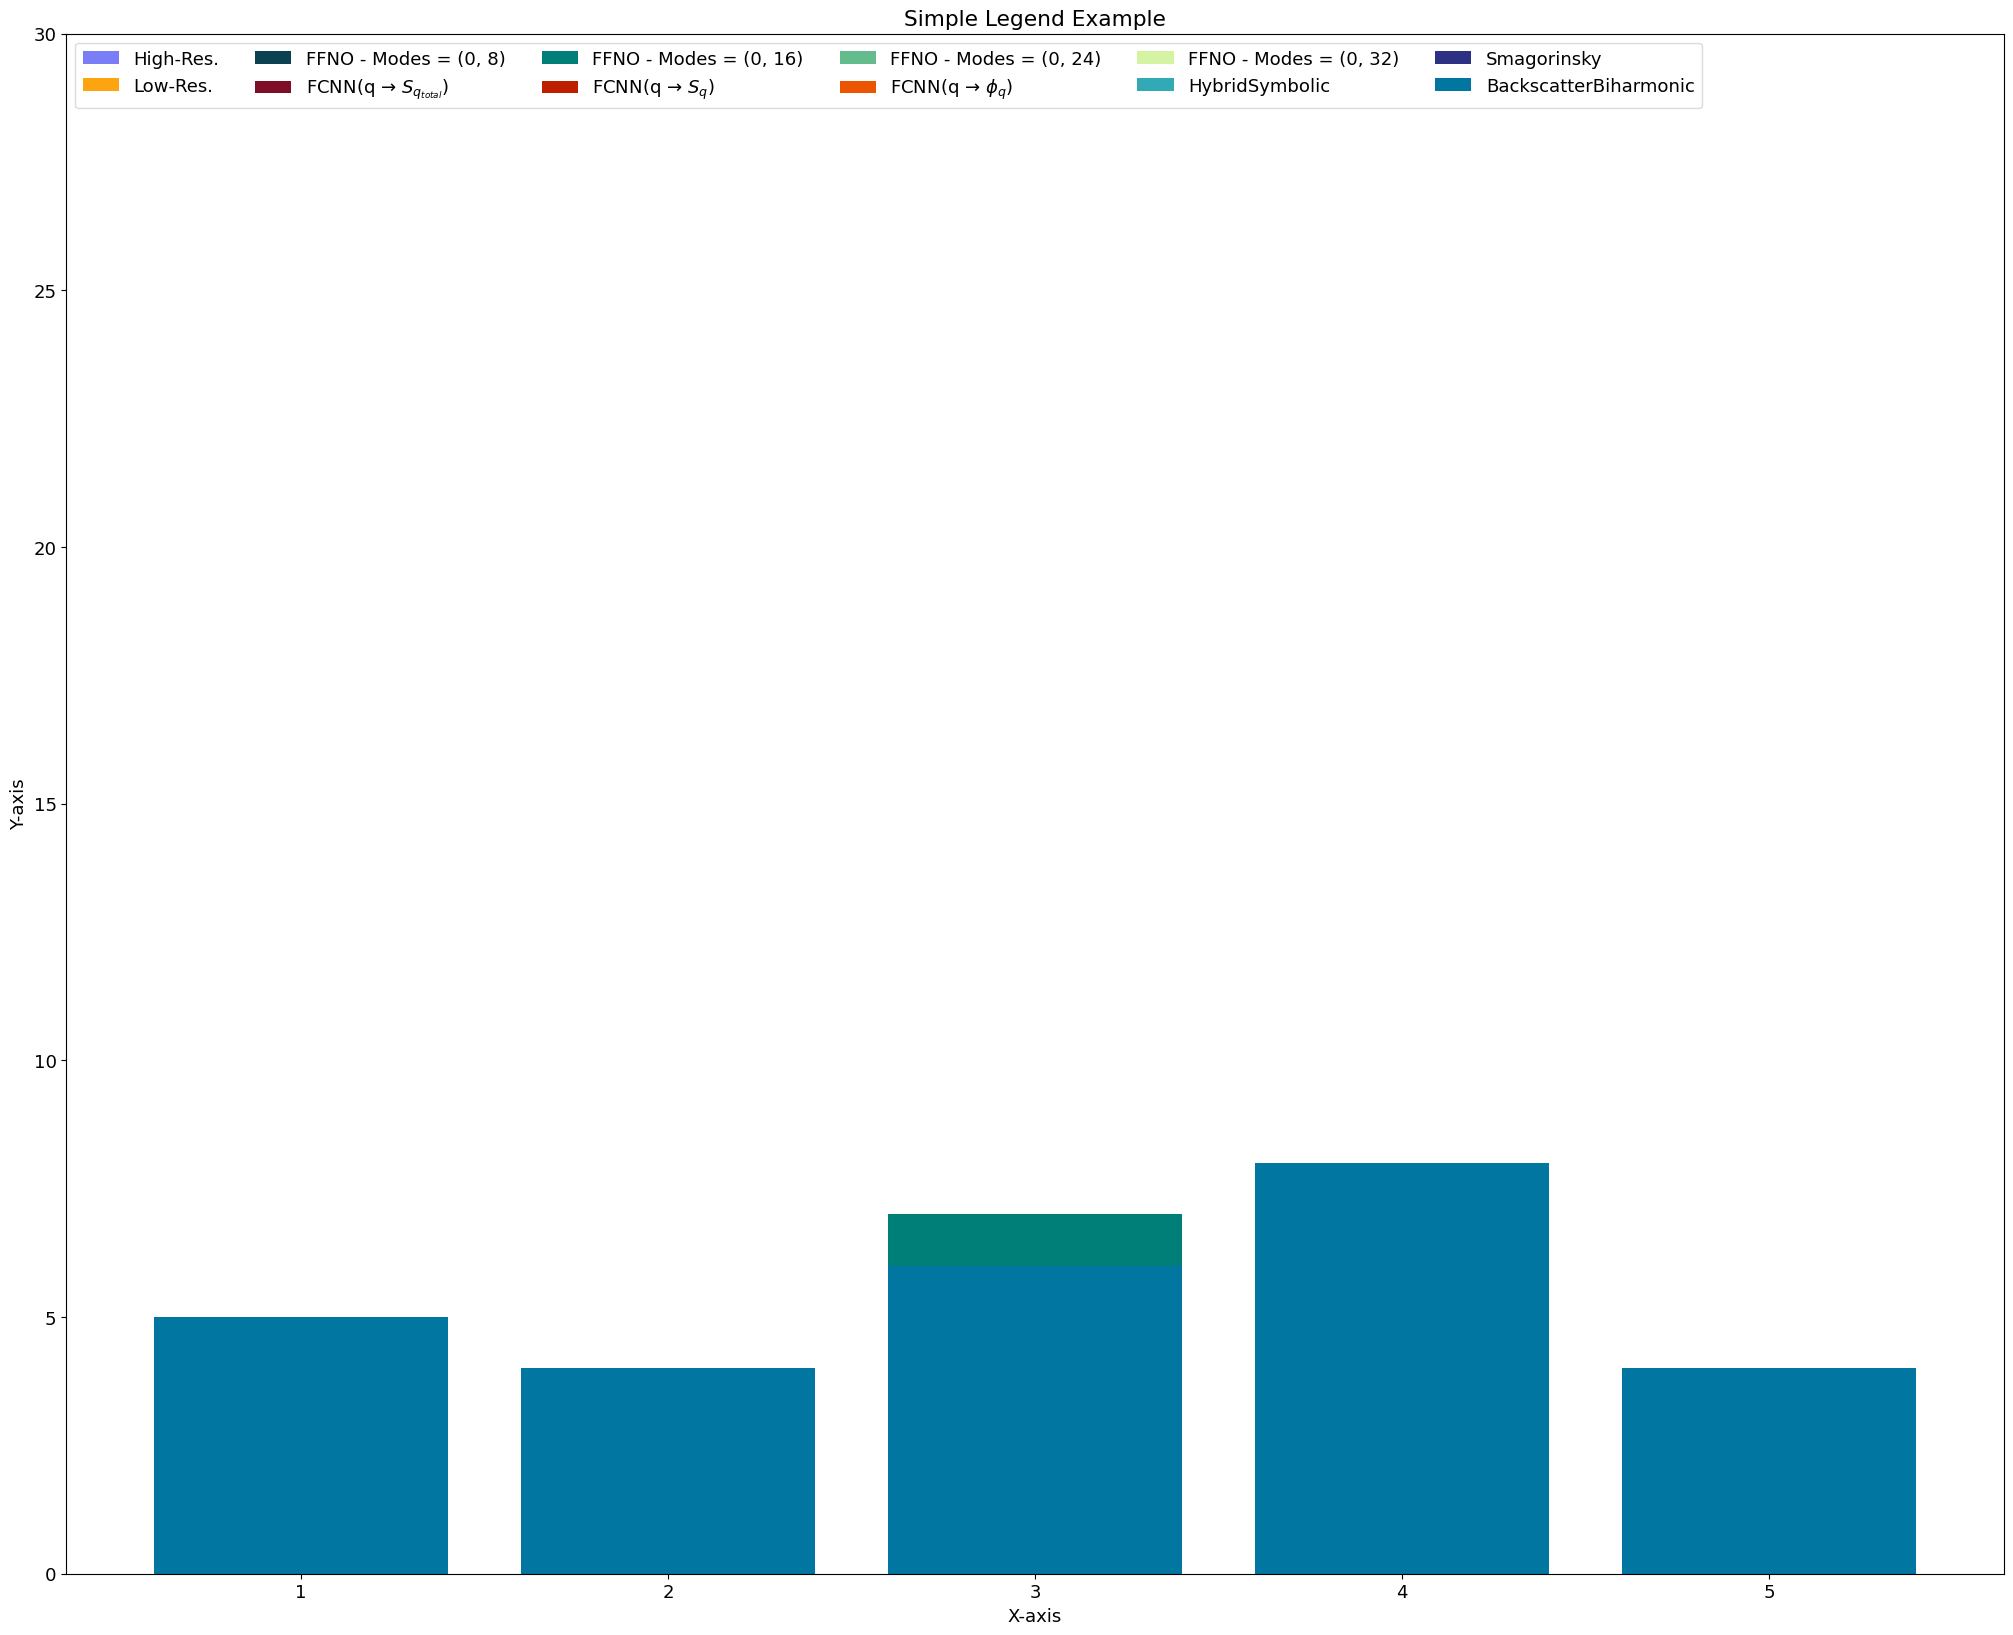

In [25]:
import matplotlib.pyplot as plt

# Sample data
x  = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]
y2 = [1, 3, 5, 7, 9]
y1 = [5, 4, 6, 8, 4]
y2 = [1, 3, 7, 7, 2]

    
fig = plt.figure(figsize = (25, 20))
    
# Create a plot
plt.bar(x, y1, label=r'High-Res.', color = color_hr)
plt.bar(x, y2, label=r'Low-Res.', color  = color_lr)

plt.bar(x, y1, label=r'FFNO - Multi-Step', color = color_param[0])
plt.bar(x, y2, label=r"FCNN(q → $S_{q_{total}}$)", color = color_nn[0])

plt.bar(x, y2, label=r'FFNO - Cosine', color = color_param[1])
plt.bar(x, y1, label=r"FCNN(q → $S_{q}$)",         color = color_nn[1])

plt.bar(x, y1, label=r'FFNO - Constant - LR = 0.01',  color = color_param[2])
plt.bar(x, y1, label=r"FCNN(q → $\phi_{q}$)",      color = color_nn[2])

plt.bar(x, y1, label=r'FFNO - Constant - LR = 0.001', color = color_param[3])
plt.bar(x, y1, label=r'HybridSymbolic',        color = color_anal[2])

plt.bar(x, y1, label=r'Smagorinsky',           color = color_anal[0])
plt.bar(x, y1, label=r'BackscatterBiharmonic', color = color_anal[1])



# Add a legend with customizable parameters
plt.legend(
    loc='upper left',      # Location of the legend (options: 'upper', 'lower', 'center', etc.)
    fontsize='medium',    # Font size of the legend labels
    shadow=False,          # Display shadow behind the legend
    frameon=True,         # Display a border around the legend
    framealpha=0.7,       # Transparency of the legend border
    fancybox=True,         # Use rounded corners for the legend border
    ncol=6,
    #title=r"FFNO modes - Width = 128 - Num. Lay. = 24"
)

# Add labels and title
plt.xlabel('X-axis')
plt.ylim([0, 30])
plt.ylabel('Y-axis')
plt.title('Simple Legend Example')

# Show the plot
plt.savefig("NEW_LEGEND.svg", bbox_inches='tight')
plt.show()